In [50]:
# Importação das bibliotecas
import csv
import igraph as ig
import pandas as pd

In [51]:
# Funções
def yyyymmdd_to_Timestamp(str_date, default_Timestamp): 
    return pd.to_datetime(str_date, format = '%Y%m%d') if (str_date.strip() != '') and (len(str_date) == 8) and (str_date.isdigit()) and  (str_date[:2] in ['19', '20']) else default_Timestamp

def is_null(x) -> bool:
    return pd.isnull(x) if (type(pd.isnull(x)) is bool) else False

def is_contratacao_impedida(v_licit_contrato, v_sancao):    
    licit_contrato_ini = v_licit_contrato['data_ini']
    licit_contrato_fim = v_licit_contrato['data_fim']
    sancao_ini = v_sancao['data_ini']
    sancao_fim = v_sancao['data_fim']
    is_imped = ((licit_contrato_ini <= sancao_fim) and (licit_contrato_fim >= sancao_ini)) \
                if ((not is_null(licit_contrato_ini)) and 
                    (not is_null(licit_contrato_fim)) and 
                    (not is_null(sancao_ini)) and 
                    (not is_null(sancao_fim))) \
                else False
                   
    return is_imped

def is_path_contratacao_impedida(shortest_paths, i, j):
    if (2 <= shortest_paths[0][j] <= 4):
        vpath_imped_n = graph.get_shortest_paths(i, j, output = 'vpath')[0]
        vpath_imped_tipo = [graph.vs[n]['tipo'] for n in vpath_imped_n]
        
        count_contrato = vpath_imped_tipo.count('C')
        count_licitacao = vpath_imped_tipo.count('L')
        count_fornec = vpath_imped_tipo.count('F')
        count_socio = vpath_imped_tipo.count('S')
        count_empregado = vpath_imped_tipo.count('E')        
        count_sancao = vpath_imped_tipo.count('Sa')
        
        if (((count_contrato + count_licitacao) == 1) and
            (count_fornec in [1, 2]) and
            (count_socio in [0, 1]) and
            ((count_empregado + count_sancao) == 1)):
            
            if (count_empregado == 1):
                return True
            else:
                vpath_imped = [graph.vs[n] for n in vpath_imped_n]                
                for vs in vpath_imped:
                    if vs['tipo'] in ['C', 'L']:
                        v_licit_contrato = vs
                    elif vs['tipo'] == 'Sa':
                        v_sancao = vs
                return is_contratacao_impedida(v_licit_contrato, v_sancao)
        else:
            return False
        
print('Funções criadas: yyyymmdd_to_Timestamp, isnull, is_contratacao_impedida, is_path_contratacao_impedida')

Funções criadas: yyyymmdd_to_Timestamp, isnull, is_contratacao_impedida, is_path_contratacao_impedida


In [52]:
# Cria do Grafo
with open('..\input\graph_edges.csv', mode = 'r', encoding = 'utf-8-sig') as csv_edges:
    dict_edges = csv.DictReader(csv_edges, delimiter = ';')
    graph = ig.Graph.DictList(vertices = None, edges = dict_edges, directed = False)

# Define novas propriedades para os vértices
for vs in graph.vs:
    props = vs['name'].split('-')
    vs['tipo'] = props[0]
    vs['subtipo'] = props[1]
    vs['id'] = props[2]
    vs['data_ini'] = yyyymmdd_to_Timestamp(props[3], pd.Timestamp.min) if (len(props) > 3) else None
    vs['data_fim'] = yyyymmdd_to_Timestamp(props[4], pd.Timestamp.max) if (len(props) > 4) else None
    vs['label'] = f"{vs['tipo']}-{vs['id']}"
    
print(f"Grafo criado ({len(graph.vs)} vértices, {len(graph.es)} arestas)")

Grafo criado (28 vértices, 27 arestas)


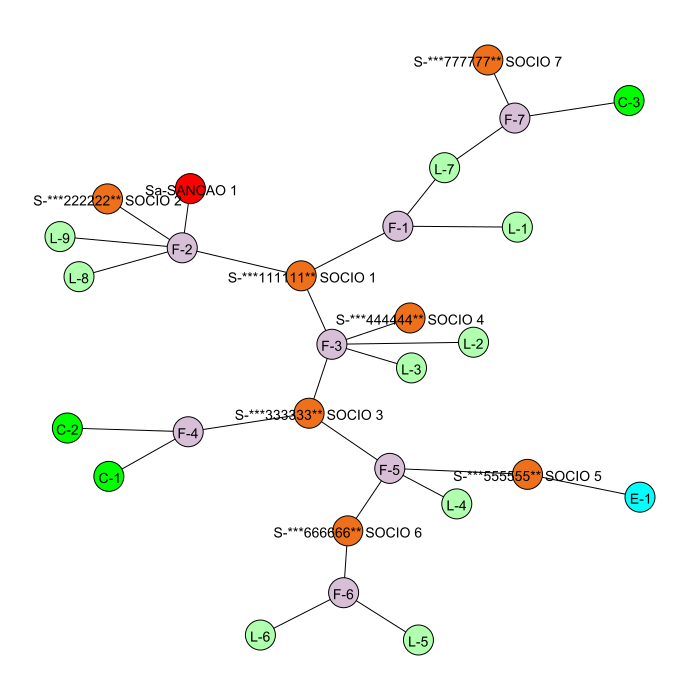

In [53]:
# Visualiza o grafo
coresdict = {'L':'#AFFFAF', 'C':'#00FF00', 'F':'#D8BFD8', 'E':'#00FFFF', 'S':'#EE701B', 'Sa':'#FF0000'}
cores = [coresdict[vs['tipo']] for vs in graph.vs]

ig.plot(graph, 
        bbox = (0, 0, 700, 700), 
        margin = 60,
        vertex_size = 30,
        vertex_color = cores,
        edge_color = 'black')

In [54]:
# Identifica os impedimentos
v_impedimentos = []
e_impedimentos = []
for vs in graph.vs:    
    i = vs.index
    shortest_paths = graph.shortest_paths(source = i)

    for j in range(i, len(shortest_paths[0])):
        if is_path_contratacao_impedida(shortest_paths, i, j):
            vpath_imped = graph.get_shortest_paths(i, j, output = 'vpath')[0]
            v_impedimentos.append(vpath_imped)
            epath_imped = graph.get_shortest_paths(i, j, output = 'epath')[0]
            e_impedimentos.append(epath_imped)
        
print(f"{len(e_impedimentos)} impedimentos identificados")

7 impedimentos identificados


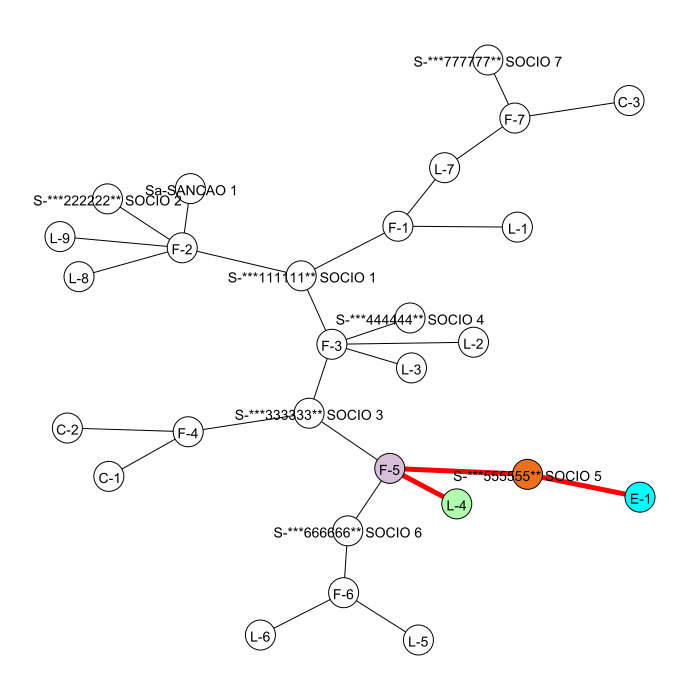

In [55]:
# Visualiza 1º exemplo de impedimento
# Empresa (F-5) cujo Sócio é um Empregado
indice_imped = 3

v_cores = [coresdict[vs['tipo']] if vs.index in v_impedimentos[indice_imped] else '#FFFFFF' for vs in graph.vs]
e_cores = ['#FF0000' if es.index in e_impedimentos[indice_imped] else '#000000' for es in graph.es]
e_width = [5 if es.index in e_impedimentos[indice_imped] else 1 for es in graph.es]
ig.plot(graph, 
        bbox = (0, 0, 700, 700), 
        margin = 60,
        vertex_size = 30,
        vertex_color = v_cores,
        edge_color = e_cores,
        edge_width = e_width)

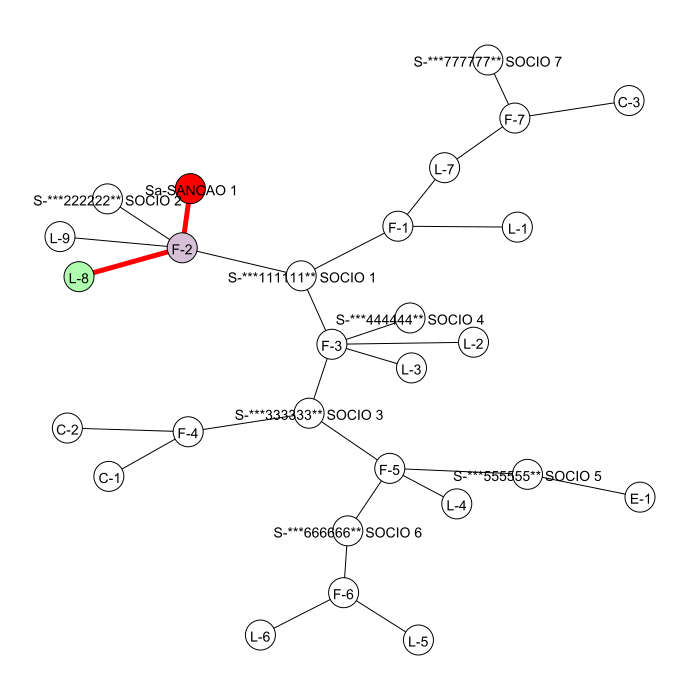

In [56]:
# Visualiza 2º exemplo de impedimento
# Empresa (F-2) Inidônea
indice_imped = 5

v_cores = [coresdict[vs['tipo']] if vs.index in v_impedimentos[indice_imped] else '#FFFFFF' for vs in graph.vs]
e_cores = ['#FF0000' if es.index in e_impedimentos[indice_imped] else '#000000' for es in graph.es]
e_width = [5 if es.index in e_impedimentos[indice_imped] else 1 for es in graph.es]
ig.plot(graph, 
        bbox = (0, 0, 700, 700), 
        margin = 60,
        vertex_size = 30,
        vertex_color = v_cores,
        edge_color = e_cores,
        edge_width = e_width)

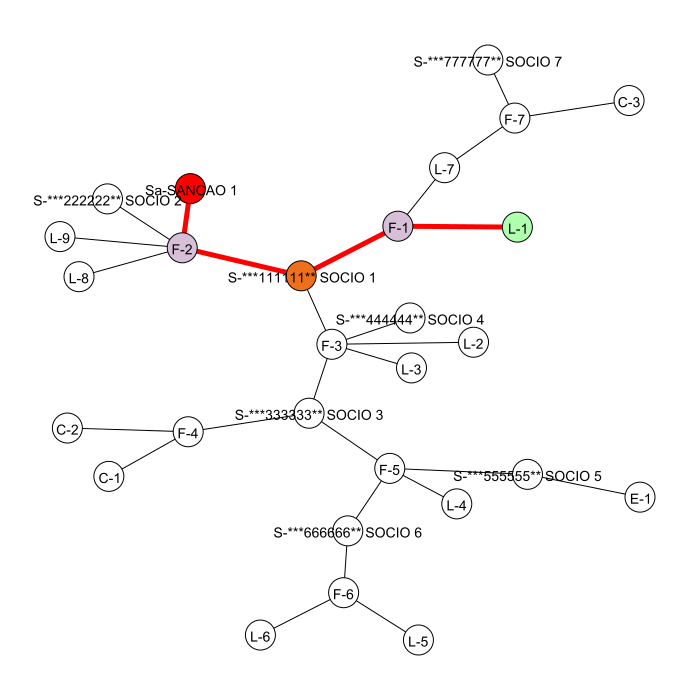

In [57]:
# Visualiza 3o exemplo de impedimento
# Empresa (F-1) Idônea Constituída por Sócio de Empresa Inidônea
indice_imped = 0

v_cores = [coresdict[vs['tipo']] if vs.index in v_impedimentos[indice_imped] else '#FFFFFF' for vs in graph.vs]
e_cores = ['#FF0000' if es.index in e_impedimentos[indice_imped] else '#000000' for es in graph.es]
e_width = [5 if es.index in e_impedimentos[indice_imped] else 1 for es in graph.es]
ig.plot(graph, 
        bbox = (0, 0, 700, 700), 
        margin = 60,
        vertex_size = 30,
        vertex_color = v_cores,
        edge_color = e_cores,
        edge_width = e_width)